In [1]:
import json

with open('documents-with-ids.json', 'rt',  encoding='utf-8') as f_in:
    documents = json.load(f_in)

documents[20]

{'text': 'El Centro Histórico tiene un 34.9% de viviendas con apenas un dormitorio, indicando una condición de hacinamiento.',
 'section': 'Bienestar Social',
 'question': '¿Cuál es el porcentaje de viviendas con apenas un dormitorio en el Centro Histórico?',
 'topic': 'PMD',
 'id': '9079cdc6'}

In [2]:
import pandas as pd
df_ground_truth = pd.read_csv('ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')
ground_truth[20]

{'question': '¿Cuál es la relación entre turismo y economía local?',
 'topic': 'PMD',
 'document': '21b7970e'}

In [3]:
doc_idx = {d['id']: d for d in documents}
doc_idx['21b7970e']['text']

'El turismo representa una actividad de primera importancia para el desarrollo económico de Puebla.'

In [4]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

D:\Anaconda\envs\centro_historico\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda\envs\centro_historico\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "topic": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "ch-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ch-questions'})

In [6]:
import elasticsearch
print(elasticsearch.__version__)

(8, 14, 0)


In [7]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    qt = question + ' ' + text

    doc['question_vector'] = model.encode(question)
    doc['text_vector'] = model.encode(text)
    doc['question_text_vector'] = model.encode(qt)
    es_client.index(index=index_name, document=doc)

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [00:17<00:00, 10.56it/s]


In [8]:
def elastic_search_knn_combined(vector, topic):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": [
                    {
                        "script_score": {
                            "query": {
                                "term": {
                                    "topic": topic
                                }
                            },
                            "script": {
                                "source": """
                                    cosineSimilarity(params.query_vector, 'question_vector') + 
                                    cosineSimilarity(params.query_vector, 'text_vector') + 
                                    cosineSimilarity(params.query_vector, 'question_text_vector') + 
                                    1
                                """,
                                "params": {
                                    "query_vector": vector
                                }
                            }
                        }
                    }
                ],
                "filter": {
                    "term": {
                        "topic": topic
                    }
                }
            }
        },
        "_source": ["text", "section", "question", "topic", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [9]:
def vector_combined_knn(q):
    question = q['question']
    topic = q['topic']

    v_q = model.encode(question)

    return elastic_search_knn_combined(v_q, topic)

In [10]:
vector_combined_knn(dict(
    question='¿Cuál es la relación entre turismo y economía local?',
    topic='PMD'
))

[{'question': '¿Qué importancia tiene el turismo para el desarrollo económico de Puebla?',
  'topic': 'PMD',
  'section': 'Turismo',
  'text': 'El turismo representa una actividad de primera importancia para el desarrollo económico de Puebla.',
  'id': '21b7970e'},
 {'question': '¿Cómo contribuyen los reconocimientos de la UNESCO al turismo en Puebla?',
  'topic': 'PMD',
  'section': 'Turismo',
  'text': 'Los reconocimientos de la UNESCO otorgados al municipio en materia cultural constituyen una ventaja competitiva que fortalece su vocación turística.',
  'id': '3b870dae'},
 {'question': '¿Cuál fue la tasa media anual de crecimiento poblacional en la zona metropolitana en el último decenio?',
  'topic': 'PMD',
  'section': 'Densidad poblacional',
  'text': 'En el último decenio, la zona metropolitana registró su menor crecimiento poblacional con una tasa media anual de 0.9%. Esta situación contrasta con las altas tasas de crecimiento de municipios como Cuautlancingo, San Andrés Cholula

In [51]:
def build_prompt(query, search_results):
    prompt_template = """
Tu eres un experto en el municipio de Puebla y el Centro Histórico de Puebla. Responde la PREGUNTA basandote en el CONTEXTO proveniente de la base de datos FAQ.
Se conciso, claro y da la mejor respuesta. Usando unicamente los hechos provenientes del CONTEXTO cuando respondas la PREGUNTA.


PREGUNTA: {question}

CONTEXTO 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [12]:
from openai import OpenAI

client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
)

def llm(prompt, model='llama3.1'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [13]:
def rag(query: dict, model='llama3.1') -> str:
    search_results = vector_combined_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [50]:
rag(ground_truth[20])

'La relación entre turismo y economía local en Puebla es muy importante, ya que el turismo representa una actividad de primera importancia para el desarrollo económico del municipio. Además, los reconocimientos de la UNESCO han fortalecido la vocación turística de Puebla y constituyen una ventaja competitiva. Esto sugiere que el turismo tiene un impacto positivo en la economía local de Puebla.'

In [15]:
doc_idx['21b7970e']['text']

'El turismo representa una actividad de primera importancia para el desarrollo económico de Puebla.'

In [52]:
answer_llm = 'La relación entre turismo y economía local en Puebla es muy importante, ya que el turismo representa una actividad de primera importancia para el desarrollo económico del municipio. Además, los reconocimientos de la UNESCO han fortalecido la vocación turística de Puebla y constituyen una ventaja competitiva. Esto sugiere que el turismo tiene un impacto positivo en la economía local de Puebla.'
answer_orig = 'El turismo representa una actividad de primera importancia para el desarrollo económico de Puebla.'
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.8444394

In [17]:
answers = {}

In [22]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=8)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [23]:
def process_record(rec):
    model = 'llama3.1'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'topic': rec['topic'],
    }

In [56]:
process_record(ground_truth[91])

{'answer_llm': 'La respuesta a tu pregunta sobre el acceso de las familias al sistema RUTA en Puebla según el Programa de Vivienda es lo siguiente:\n\nEl 50% de las familias del municipio tiene acceso al transporte RUTA.',
 'answer_orig': 'El Programa de Vivienda para el Municipio de Puebla señala que apenas 50% de las familias en el municipio tiene acceso al transporte RUTA.',
 'document': '858b5299',
 'question': '¿Qué indica el Programa de Vivienda sobre el acceso de las familias al sistema RUTA en Puebla?',
 'topic': 'PMD'}

In [57]:
answer_orig = 'El Programa de Vivienda para el Municipio de Puebla señala que apenas 50% de las familias en el municipio tiene acceso al transporte RUTA.'
answer_llm = 'La respuesta a tu pregunta sobre el acceso de las familias al sistema RUTA en Puebla según el Programa de Vivienda es lo siguiente:\n\nEl 50% de las familias del municipio tiene acceso al transporte RUTA.'
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.8610551

In [58]:
results_llama = map_progress(pool, ground_truth, process_record)

100%|██████████████████████████████████████████████████████████████████████████████| 370/370 [4:52:04<00:00, 47.36s/it]


In [61]:
df_llama = pd.DataFrame(results_llama)
df_llama.to_csv('results-llama.csv', index=False)

In [63]:
df_llama.head()

,answer_llm,answer_orig,document,question,topic
0,La acción que ayudará al Eje 4 a proteger los ...,El Eje 4 contribuirá al repoblamiento y mejora...,335b2f94,¿Qué acción ayudará al Eje 4 a proteger los el...,PMD
1,La respuesta a la pregunta es:\n\nEl Eje 4 con...,El Eje 4 contribuirá al repoblamiento y mejora...,335b2f94,En qué medida el Eje 4 contribuirá al mejorami...,PMD
2,"Basándome en el contexto proporcionado, los ob...",El Plan de Manejo del Centro Histórico de Pueb...,805017f9,¿Cuáles son los objetivos principales del Plan...,PMD
3,"Basándome en el contexto proporcionado, las ac...",El Plan de Manejo del Centro Histórico de Pueb...,805017f9,¿Qué acciones se llevarán a cabo para lograr u...,PMD
4,La política abordada por los programas parcial...,Los programas parciales de desarrollo urbano d...,017273c8,¿Qué política abordan los programas parciales ...,PMD


In [99]:
df_llama = pd.read_csv('results-llama.csv')

In [100]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [101]:
results_df = df_llama.to_dict(orient='records')

similarity_llama = []

for record in tqdm(results_df):
    sim = compute_similarity(record)
    similarity_llama.append(sim)

100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [00:15<00:00, 23.72it/s]


In [102]:
df_llama['cosine'] = similarity
df_llama['cosine'].describe()

count    370.000000
mean       0.722291
std        0.149195
min        0.276554
25%        0.647168
50%        0.752806
75%        0.827955
max        1.000000
Name: cosine, dtype: float64

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

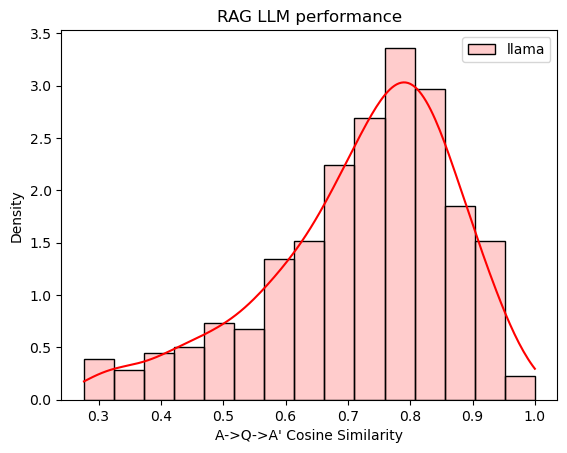

In [105]:
sns.histplot(df_llama['cosine'], kde=True, label='llama', color='red', stat='density', alpha=0.2)
            
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()